Objective: Generalize Admin Driver model from Summer 2019 for the past year of Admin data from users with one Seat.

In [4]:
import os
import csv
import math
import pandas as pd
import numpy as np
import datetime

import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc
from sklearn.metrics import  f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
import os

from sklearn.linear_model import LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, OneClassSVM
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

In [27]:
d = '('+str(datetime.datetime.today().month)+'-'+str(datetime.datetime.today().day)+'-'+str(datetime.datetime.today().year)+')'
df = pd.read_csv('SingleSeatAdminOneYear.csv', index_col=0)

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (22,84,95,96,127,149,173,175,177,178,179,180,185,186,187,190,192,194,199,204,205,206,207,208,211,213,214,226,227,228,229,230,234) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
df.shape

(34674, 311)

In [64]:
def transform_rating(rating):
    '''Input: Column of Data with NPS Field (on a scale of 1 to 5...)
    Output: Column with either Promoter/Detractor/Passive label, or the corresponding weights, based on datatype'''
    
    if rating == 5:
        return 3
    elif rating <= 3:
        return 1
    elif rating == 4:
        return 2
    else:
        return np.nan
    
df['NPS'] = df['Feedback_Rating'].apply(transform_rating)

In [65]:
tenants = df.Feedback_TenantId.value_counts()[df.Feedback_TenantId.value_counts().values>=1]
df = df[df['Feedback_TenantId'].isin(tenants.index)]
df[df['Feedback_TenantId'].isin(tenants.index)].groupby(['Feedback_TenantId'])['NPS'].value_counts()[:10]

Feedback_TenantId                     NPS
000004fc-1c88-4932-b46b-01e2f7e6180e  3      1
00025d88-6d9a-44e3-98a8-720ce4cae861  3      1
0009624e-d096-4ec5-b0a4-e8c4b7fb04f8  1      1
0009c2a7-42e5-4169-9c16-464eccb0f404  3      1
000a9cb1-a5d9-45fe-bfcd-689855653cb9  3      1
000eb669-8394-4e90-9e7e-b575ecc2fc0a  3      1
00200e13-3888-491c-a124-043bd1f7913d  3      1
002b20d0-8b50-40ab-a604-78d77d57537d  1      1
002b50fa-541b-4b21-8281-9b6db2aa1a5a  1      1
002bb352-2f4d-422e-9122-893cfc6c2f12  2      1
Name: NPS, dtype: int64

In [66]:
modes = df[df['Feedback_TenantId'].isin(tenants.index)].groupby(['Feedback_TenantId'])['NPS'].apply(pd.Series.mode)
ties = modes[modes.groupby(level=0).transform('count') > 1]
modes = modes[modes.groupby(level=0).transform('count') == 1] #remove ties
modes[:5]

Feedback_TenantId                      
000004fc-1c88-4932-b46b-01e2f7e6180e  0    3
00025d88-6d9a-44e3-98a8-720ce4cae861  0    3
0009624e-d096-4ec5-b0a4-e8c4b7fb04f8  0    1
0009c2a7-42e5-4169-9c16-464eccb0f404  0    3
000a9cb1-a5d9-45fe-bfcd-689855653cb9  0    3
Name: NPS, dtype: int64

In [67]:
df.Feedback_TenantId.value_counts()

7d23bfcf-e434-4334-b7af-11078aa3d028    1
77840840-29fe-48b7-a71a-786145e45eca    1
fc25c95a-9ebe-4aa7-8310-9e5bba5fe851    1
bfb992b6-814f-4872-8533-f85a8f595d3c    1
0592b684-50cc-4ea6-8fa9-96fe2ef63339    1
e177bc1a-f601-4905-b764-7a0ab6f0e428    1
c62707e2-2138-4e3a-96af-dd7844315312    1
31eda24e-8478-448f-b1ca-95fce3df7caa    1
f29dd956-ac1f-476c-97fc-5ecfcb136f36    1
f8becad7-f8ba-45ee-80ef-b91cf685ab46    1
e4ab7a2a-08d6-411c-a1ea-6d3ac1f313e7    1
6f935372-389a-4b78-9326-42c922013d69    1
82aa42ed-1507-4a44-be4e-fe24b6e7133c    1
ca724e49-9094-43b5-a305-f58a9330b22e    1
257447b6-7542-45ab-afdd-78e302ff77fb    1
c20a6a84-02ff-4c8d-a2e4-4a9a6d599979    1
b049977e-9e42-4f6a-b06c-f4ce97b77f10    1
88b7609c-e5ae-4a2b-8a1c-d0a2c3012726    1
cef65473-dbb9-400f-b57f-306d56d71b25    1
922ca19c-352c-4c41-8ba8-02ee2a1c2364    1
89d96660-7285-4702-8a56-d4d6f3d4c678    1
801c8d58-4225-4a34-8d46-651c1e8e1f4e    1
1f6c40b1-589a-448c-80c0-223539432934    1
6db660f0-7056-47d2-9842-18b4afb00e

In [68]:
df['TenantAttitude'] = df['Feedback_TenantId'].map(modes.to_dict())
df['TenantAttitude'].fillna(2,inplace=True)

In [69]:
df.TenantAttitude.value_counts()

2.0    14597
Name: TenantAttitude, dtype: int64

In [70]:
df.drop_duplicates(subset=['Feedback_TenantId'],inplace=True)

In [71]:
df.shape

(14597, 313)

In [72]:
df.TenantAttitude.head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: TenantAttitude, dtype: float64

In [73]:
y =  df['TenantAttitude']

## Feature Selection/Engineering:
### Matrix Reduction

In [74]:
all_null_list = []
for col in df.columns:
    if all(df[col].isnull()):
           all_null_list.append(col)

In [75]:
df.dropna(axis=1,how='all',inplace=True)

In [76]:
var_list = []
for col in df.columns:
    if df[col].nunique()>1:
           var_list.append(col)
            
df = df.loc[:,df.columns.isin(var_list)]
df.shape

(14597, 218)

In [77]:
df = df.loc[:,~df.columns.str.contains('ID')]
df = df.loc[:,~df.columns.str.contains('Id')]
df = df.loc[:,~df.columns.str.contains('Month')]
#Filter out redundant Time columns
time_to_drop = ['Tenant_CompanyLastDirSyncTime','Tenant_PasswordSyncTime'#,'LastTicket_CreatedTime','LastTicket_ClosedTime'
               ]
df.drop(columns=time_to_drop,inplace=True)

In [78]:
#Filter out redundant Date columns (not a time series model)
df = df.loc[:,~df.columns.str.contains('Date')]
df.shape

(14597, 200)

In [79]:
cats = df.columns[df.dtypes==object]
too_many_levels = []
threshold = 150
print(threshold)
for c in cats:
    if len(df[c].value_counts()) > threshold:
        too_many_levels.append(c)
too_many_levels

150


['Feedback_Verbatim',
 'Tenant_Name',
 'Tenant_City',
 'Tenant_Country',
 'Tenant_CountryCode',
 'Tenant_Region',
 'Tenant_BisLastUpdated',
 'Tenant_MSSalesCustomerOrgName',
 'Tenant_MSSalesTopParentOrgName',
 'Tenant_MSSalesCity',
 'Tenant_MSSalesState',
 'Tenant_MSSalesPostalCode',
 'Tenant_MSSalesCountryName',
 'Tenant_ATUName',
 'Tenant_CRMCompanyName',
 'Tenant_SalesTerritory',
 'Subscription_OfferList',
 'LastTicket_CreatedTime',
 'LastTicket_ClosedTime',
 'Verbatim_Details',
 'Verbatim_Themes']

In [80]:
df.drop(columns=too_many_levels,inplace=True)

In [81]:
redundant_region = [#'Tenant_Country','Tenant_CountryCode','Feedback_SystemLocale',
    'Tenant_MSSalesRegionName','Tenant_MSSalesSubRegionName',
    'Tenant_MSSalesSubRegionClusterGroupingName',
    #'Tenant_MSSalesCountryCode','Tenant_MSSalesCountryName',
    'Tenant_MSSalesAreaName','Tenant_SignupRegion',
]
df.drop(columns=redundant_region,inplace=True)

In [82]:
others_to_drop = ['Tenant_MSSalesSubsidiaryName']
df.drop(columns=others_to_drop,inplace=True)

In [83]:
df['Subscription_Sum_O365Business'] = df['Subscription_Sum_O365Business'].fillna(0)!=0 
df['Subscription_Sum_O365BusinessPremium'] =  df['Subscription_Sum_O365BusinessPremium'].fillna(0)!=0

# Feature Matrix and Independent Variable

In [84]:
y = df['NPS']
X = df.drop(columns=['NPS','Feedback_Rating','Feedback_RatingValue'])

In [85]:
y.shape, X.shape

((14597,), (14597, 170))

In [86]:
StrTo_Cat = df.columns[df.dtypes=='object']

In [87]:
for x in StrTo_Cat:
   # print(x)
    X.loc[X[x].isnull(), x] ='No_Data'
    X[x]= X[x].astype('category')
    X = pd.concat([X, pd.get_dummies(X[x], prefix=x, prefix_sep='_',)], axis = 1)
    del X[x]
    #pd.data[StrTo_Cat]= data[StrTo_Cat].astype('category')

In [88]:
X.fillna(0,inplace=True)

In [89]:
y2 = (y==1)*1 #For Detractor Model rather than Multinomial Class model

In [90]:
import sklearn.tree
from graphviz import Source
from IPython.display import SVG

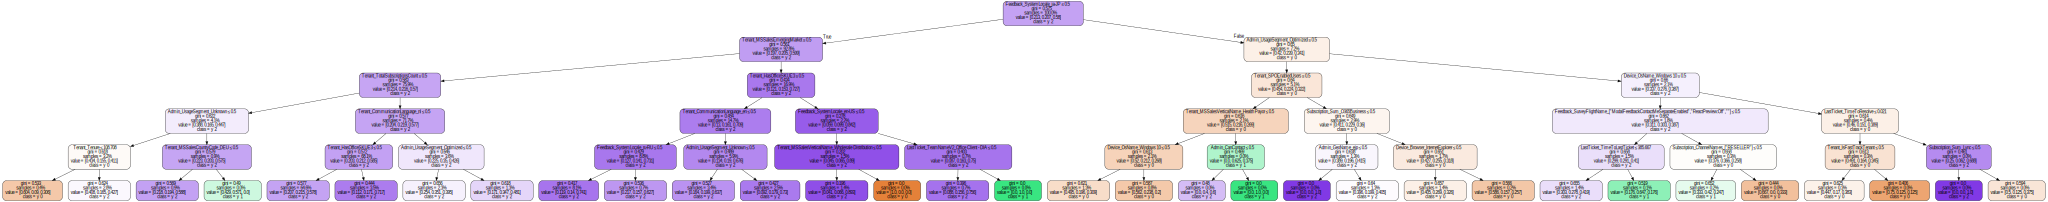

In [246]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X,y)
tree.score(X,y)

graph = Source(sklearn.tree.export_graphviz(tree,
                         class_names=True, proportion=True,
                         feature_names=X.columns,
                         out_file='training_tree.dot',filled=True, rounded=True,  
                         special_characters=True)) 
Source.from_file('training_tree.dot')

In [247]:
tree2 = DecisionTreeClassifier(max_depth=5)
tree2.fit(X,y2)
tree2.score(X,y2)
graph = Source(sklearn.tree.export_graphviz(tree2,
                         class_names=True, proportion=True,
                         feature_names=X.columns,
                         out_file='training_tree2.dot',filled=True, rounded=True,  
                         special_characters=True)) 
Source.from_file('training_tree2.dot')

Error: not well-formed (invalid token) in line 1 
... <HTML>Tenant_MSSalesSummarySegmentName_Small, Medium & Corporate Public Sector &le; 0.5 ...
in label of node 47


CalledProcessError: Command '['dot.bat', '-Tsvg']' returned non-zero exit status 1.

# Model Comparisons

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2)

In [92]:
#for XGB model, feature_names may not contain commas, as some dummies do.
for ch in [',','[',']','<']:
    X.columns = X.columns.str.replace(ch,'|') 
    X_train.columns = X_train.columns.str.replace(ch,'|') 
    X_test.columns = X_test.columns.str.replace(ch,'|')

In [93]:
print('Baseline Model Performances:')
multi_log = LogisticRegression(multi_class='multinomial', solver = 'lbfgs').fit(X,y)
rf = RandomForestClassifier(random_state=0).fit(X,y)
#ex = ExtraTreesClassifier(random_state=0).fit(X,y)
gb_model = xgb.XGBClassifier(random_state=0, n_jobs=4).fit(X,y)
learners = rf.feature_importances_.argsort()[::-1]
#learners = gb_model.feature_importances_.argsort()[::-1]
features = pd.DataFrame(X.columns[learners], gb_model.feature_importances_[learners])
#features = features[features.index>0.01]
print('Multinomial Logistic Accuracy: ',round(multi_log.score(X,y),3),
      'Random Forest: ',round(rf.score(X,y),3),  
      #'Extra Trees Accuracy: ',round(ex.score(X,y),3),
      'Gradient Boost Accuracy: ', round(gb_model.score(X,y),3)),

print('Multinomial Logistic Estimated Probabilities: ',multi_log.predict_proba(X.head(4)))
print('Random Forest Estimated Probabilities: ',rf.predict_proba(X.head(4)))
#print('Extra Trees Forest Estimated Probabilities: ',ex.predict_proba(X.head(4)))
print('Gradient Boost Estimated Probabilities: ',gb_model.predict_proba(X.head(4)))

print('Multinomial Logistic Confusion Matrix: ')
print(confusion_matrix(y,multi_log.predict(X)))
print('Random Forest Confusion Matrix: ')
print(confusion_matrix(y,rf.predict(X)))
# print('Extra Trees Confusion Matrix: ')
# print(confusion_matrix(y,ex.predict(X)))
print('Gradient Boost Confusion Matrix: ')
print(confusion_matrix(y,gb_model.predict(X)))

Baseline Model Performances:


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Multinomial Logistic Accuracy:  0.562 Random Forest:  0.984 Gradient Boost Accuracy:  0.588
Multinomial Logistic Estimated Probabilities:  [[0.15474341 0.10795067 0.73730592]
 [0.33071601 0.32897495 0.34030904]
 [0.21737121 0.20965331 0.57297548]
 [0.32724244 0.33207119 0.34068637]]
Random Forest Estimated Probabilities:  [[0.2 0.6 0.2]
 [0.7 0.2 0.1]
 [0.6 0.  0.4]
 [0.  0.1 0.9]]
Gradient Boost Estimated Probabilities:  [[0.20765294 0.22881591 0.5635311 ]
 [0.17856826 0.23301573 0.588416  ]
 [0.18667142 0.18911336 0.6242152 ]
 [0.05418753 0.10554066 0.8402718 ]]
Multinomial Logistic Confusion Matrix: 
[[   1    1 3402]
 [   0    2 2983]
 [   1    3 8204]]
Random Forest Confusion Matrix: 
[[3332    4   68]
 [  28 2875   82]
 [  33   19 8156]]
Gradient Boost Confusion Matrix: 
[[ 662    6 2736]
 [ 211   32 2742]
 [ 319    2 7887]]


In [94]:
features

,0
0.072486,Tenant_Tenure
0.018377,Admin_PortalVisits_30Days
0.011741,Admin_PortalVisits_15Days
0.007657,Device_Browser_Chrome
0.005615,"Feedback_SurveyFlightName_|""ReactPreview:On""|""..."
0.008167,Tenant_TotalSubscriptionsCount
0.029096,Admin_CanContact
0.004084,Device_OsName_Windows 10
0.007147,"Feedback_SurveyFlightName_|""ReactPreview:On""|""""|"
0.011741,Admin_UsageSegment_Core


In [95]:
features[features.index>0.01][0]

0.072486                                  Tenant_Tenure
0.018377                      Admin_PortalVisits_30Days
0.011741                      Admin_PortalVisits_15Days
0.029096                               Admin_CanContact
0.011741                        Admin_UsageSegment_Core
0.014293                   Admin_UsageSegment_Optimized
0.011230              Tenant_NonTrialSubscriptionsCount
0.019908                    LastTicket_TimeToLastTicket
0.011741                     Tenant_TotalAvailableUnits
0.012251                           Device_OsName_Mac OS
0.013783                       LastTicket_TimeToResolve
0.015314                     Admin_UsageSegment_Dormant
0.010209                     Subscription_Sum_AutoRenew
0.013783                              Admin_GeoName_eus
0.012251                    Tenant_OfficeAvailableUnits
0.012762    Tenant_MSSalesSubsidiaryPeerGroupingName_D7
0.015824                   Tenant_MSSalesEmergingMarket
0.011230                        Tenant_OD4BEnabl

In [96]:
########################################################################################################################
X_subset = X.loc[:,features[features.index>0.01][0]]
########################################################################################################################

In [97]:
X_subset.head(3)

,Tenant_Tenure,Admin_PortalVisits_30Days,Admin_PortalVisits_15Days,Admin_CanContact,Admin_UsageSegment_Core,Admin_UsageSegment_Optimized,Tenant_NonTrialSubscriptionsCount,LastTicket_TimeToLastTicket,Tenant_TotalAvailableUnits,Device_OsName_Mac OS,...,Tenant_OfficeAvailableUnits,Tenant_MSSalesSubsidiaryPeerGroupingName_D7,Tenant_MSSalesEmergingMarket,Tenant_OD4BEnabledUsers,LastTicket_CustomerRating,LastTicket_InitialTheme_No_Data,Tenant_HasOfficeSKUE3,Tenant_CommunicationLanguage_fr,Tenant_HasSubscription,Admin_GeoName_eas
0,2595.625000,0.0,0.0,0,1,0,1,0.0,1,0,...,1,1,0,1,0.0,1,0,0,1,0
1,44.666667,0.0,0.0,1,0,0,1,0.0,1,0,...,1,0,0,1,0.0,1,0,1,1,0
2,825.958333,0.0,0.0,1,0,0,2,0.0,500001,0,...,500001,0,1,1,0.0,1,0,0,1,0


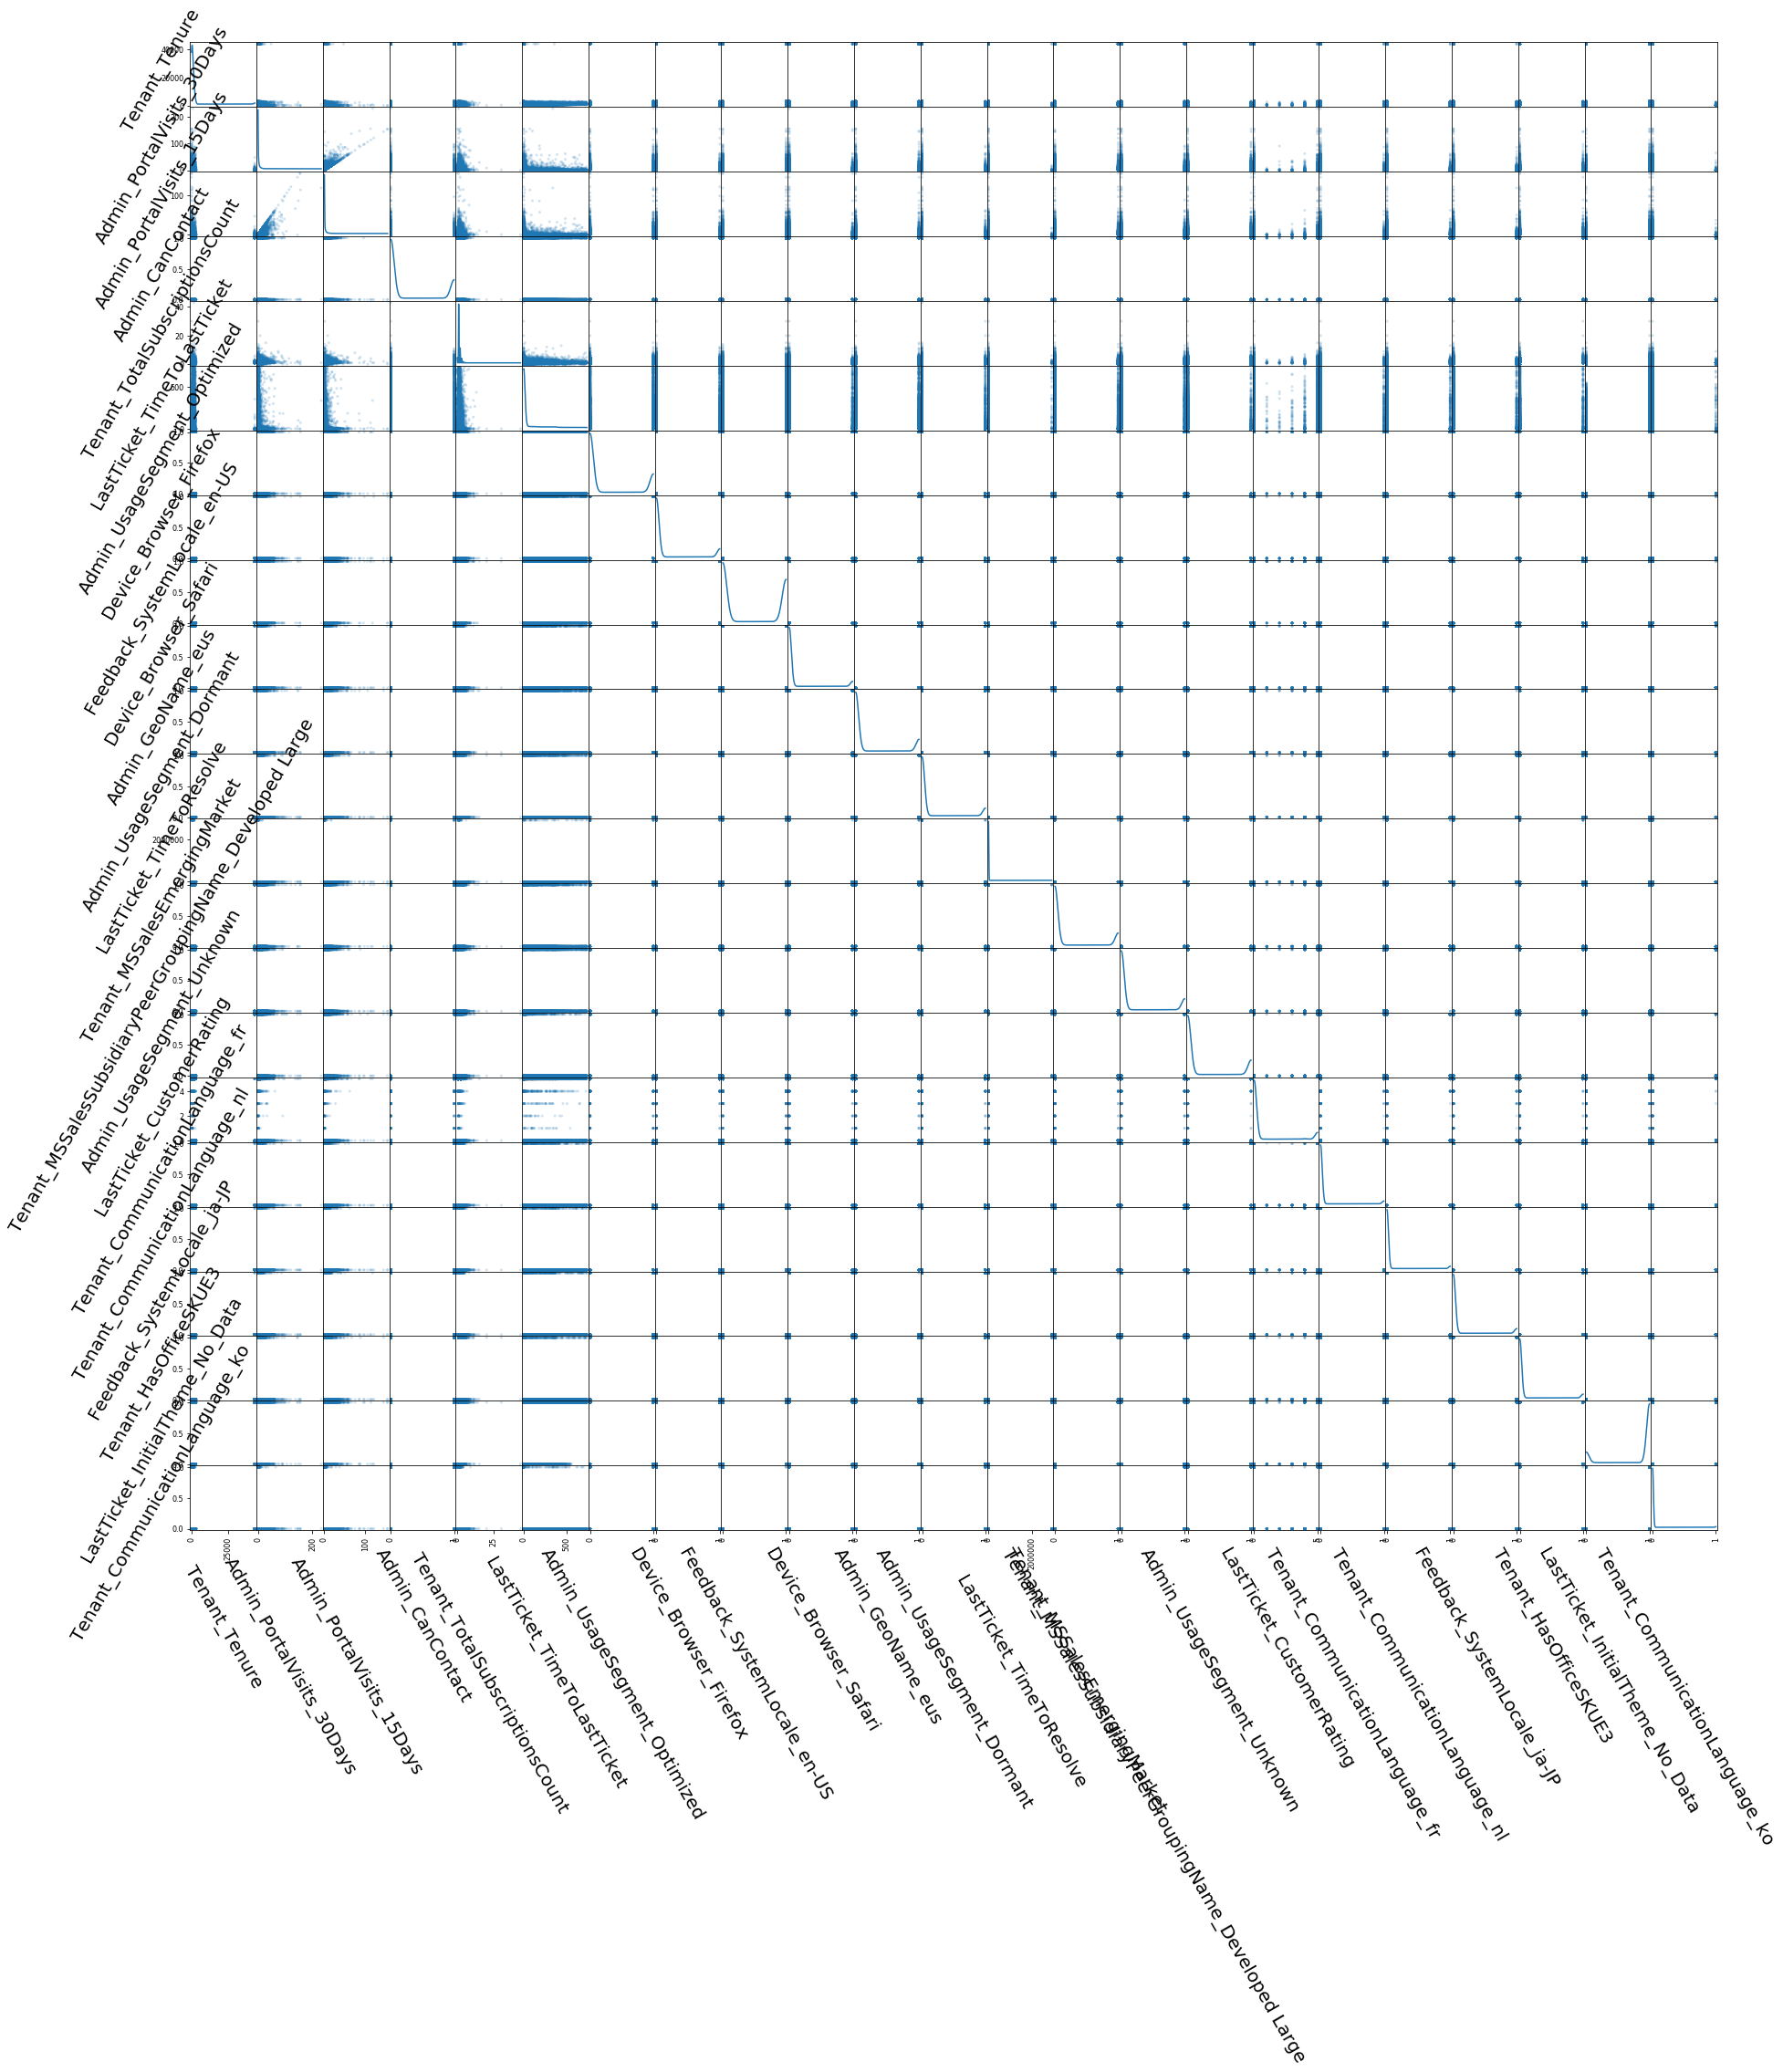

In [149]:
def make_scatter_matrix(df):
    scatter_matrix = pd.plotting.scatter_matrix(df,figsize=(30,30),
                              diagonal='kde',alpha=0.2)

    [s.xaxis.label.set_rotation(300) for s in scatter_matrix.reshape(-1)]
    [s.yaxis.label.set_rotation(60) for s in scatter_matrix.reshape(-1)]

    #May need to offset label when rotating to prevent overlap of figure
    [s.get_yaxis().set_label_coords(-0.3,0.5) for s in scatter_matrix.reshape(-1)]

    [plt.setp(item.yaxis.get_label(), 'size', 20) for item in scatter_matrix.ravel()]
    #x labels
    [plt.setp(item.xaxis.get_label(), 'size', 20) for item in scatter_matrix.ravel()]

    #Hide all ticks
    # [s.set_xticks(()) for s in sm.reshape(-1)]
    # [s.set_yticks(()) for s in sm.reshape(-1)]
    
    
make_scatter_matrix(X_subset)

In [158]:
#data = X_subset.copy()
X_subset[X_subset.columns[X_subset.dtypes=='float64']].head()

,Tenant_Tenure,Admin_PortalVisits_30Days,LastTicket_TimeToLastTicket,LastTicket_TimeToResolve,Tenant_MSSalesEmergingMarket,LastTicket_CustomerRating
Feedback_ID,,,,,,
5a78fa1e-41c4-4a9f-9556-684e42c728d7,1066.125000,0.0,0.00,0.000000,0.0,0.0
a0e3c83e-8518-4f0f-a892-e46b18947d33,20.791667,12.0,0.00,0.000000,0.0,0.0
20216231-08bc-4f25-8087-15fe26a3fbab,11.958333,4.0,0.00,0.000000,0.0,0.0
2e380529-ecce-47da-af89-dedd15697990,228.625000,0.0,0.00,0.000000,0.0,0.0
ccac5504-3423-4426-b760-da579ba2af61,175.291667,0.0,175.25,0.041667,1.0,0.0


In [98]:
X_subset.drop(columns='Admin_PortalVisits_15Days',inplace=True)

In [99]:
data = X_subset.copy()

In [204]:
Emptyto_Zero = ['Tenant_Tenure','Admin_PortalVisits_30Days',
'LastTicket_TimeToLastTicket','LastTicket_TimeToResolve', 'Tenant_TotalSubscriptionsCount']
for x in Emptyto_Zero:
    if x is not 'TenantAttitude2':
        data.loc[data[x].isnull(), x] =0
        data[x]=pd.to_numeric(data[x])
    
df_log = pd.DataFrame(data)
for c in Emptyto_Zero:
    if c is not 'TenantAttitude2':
        df_log[c]=df_log[c].apply(lambda x:0 if x <= 0 else math.log(x))

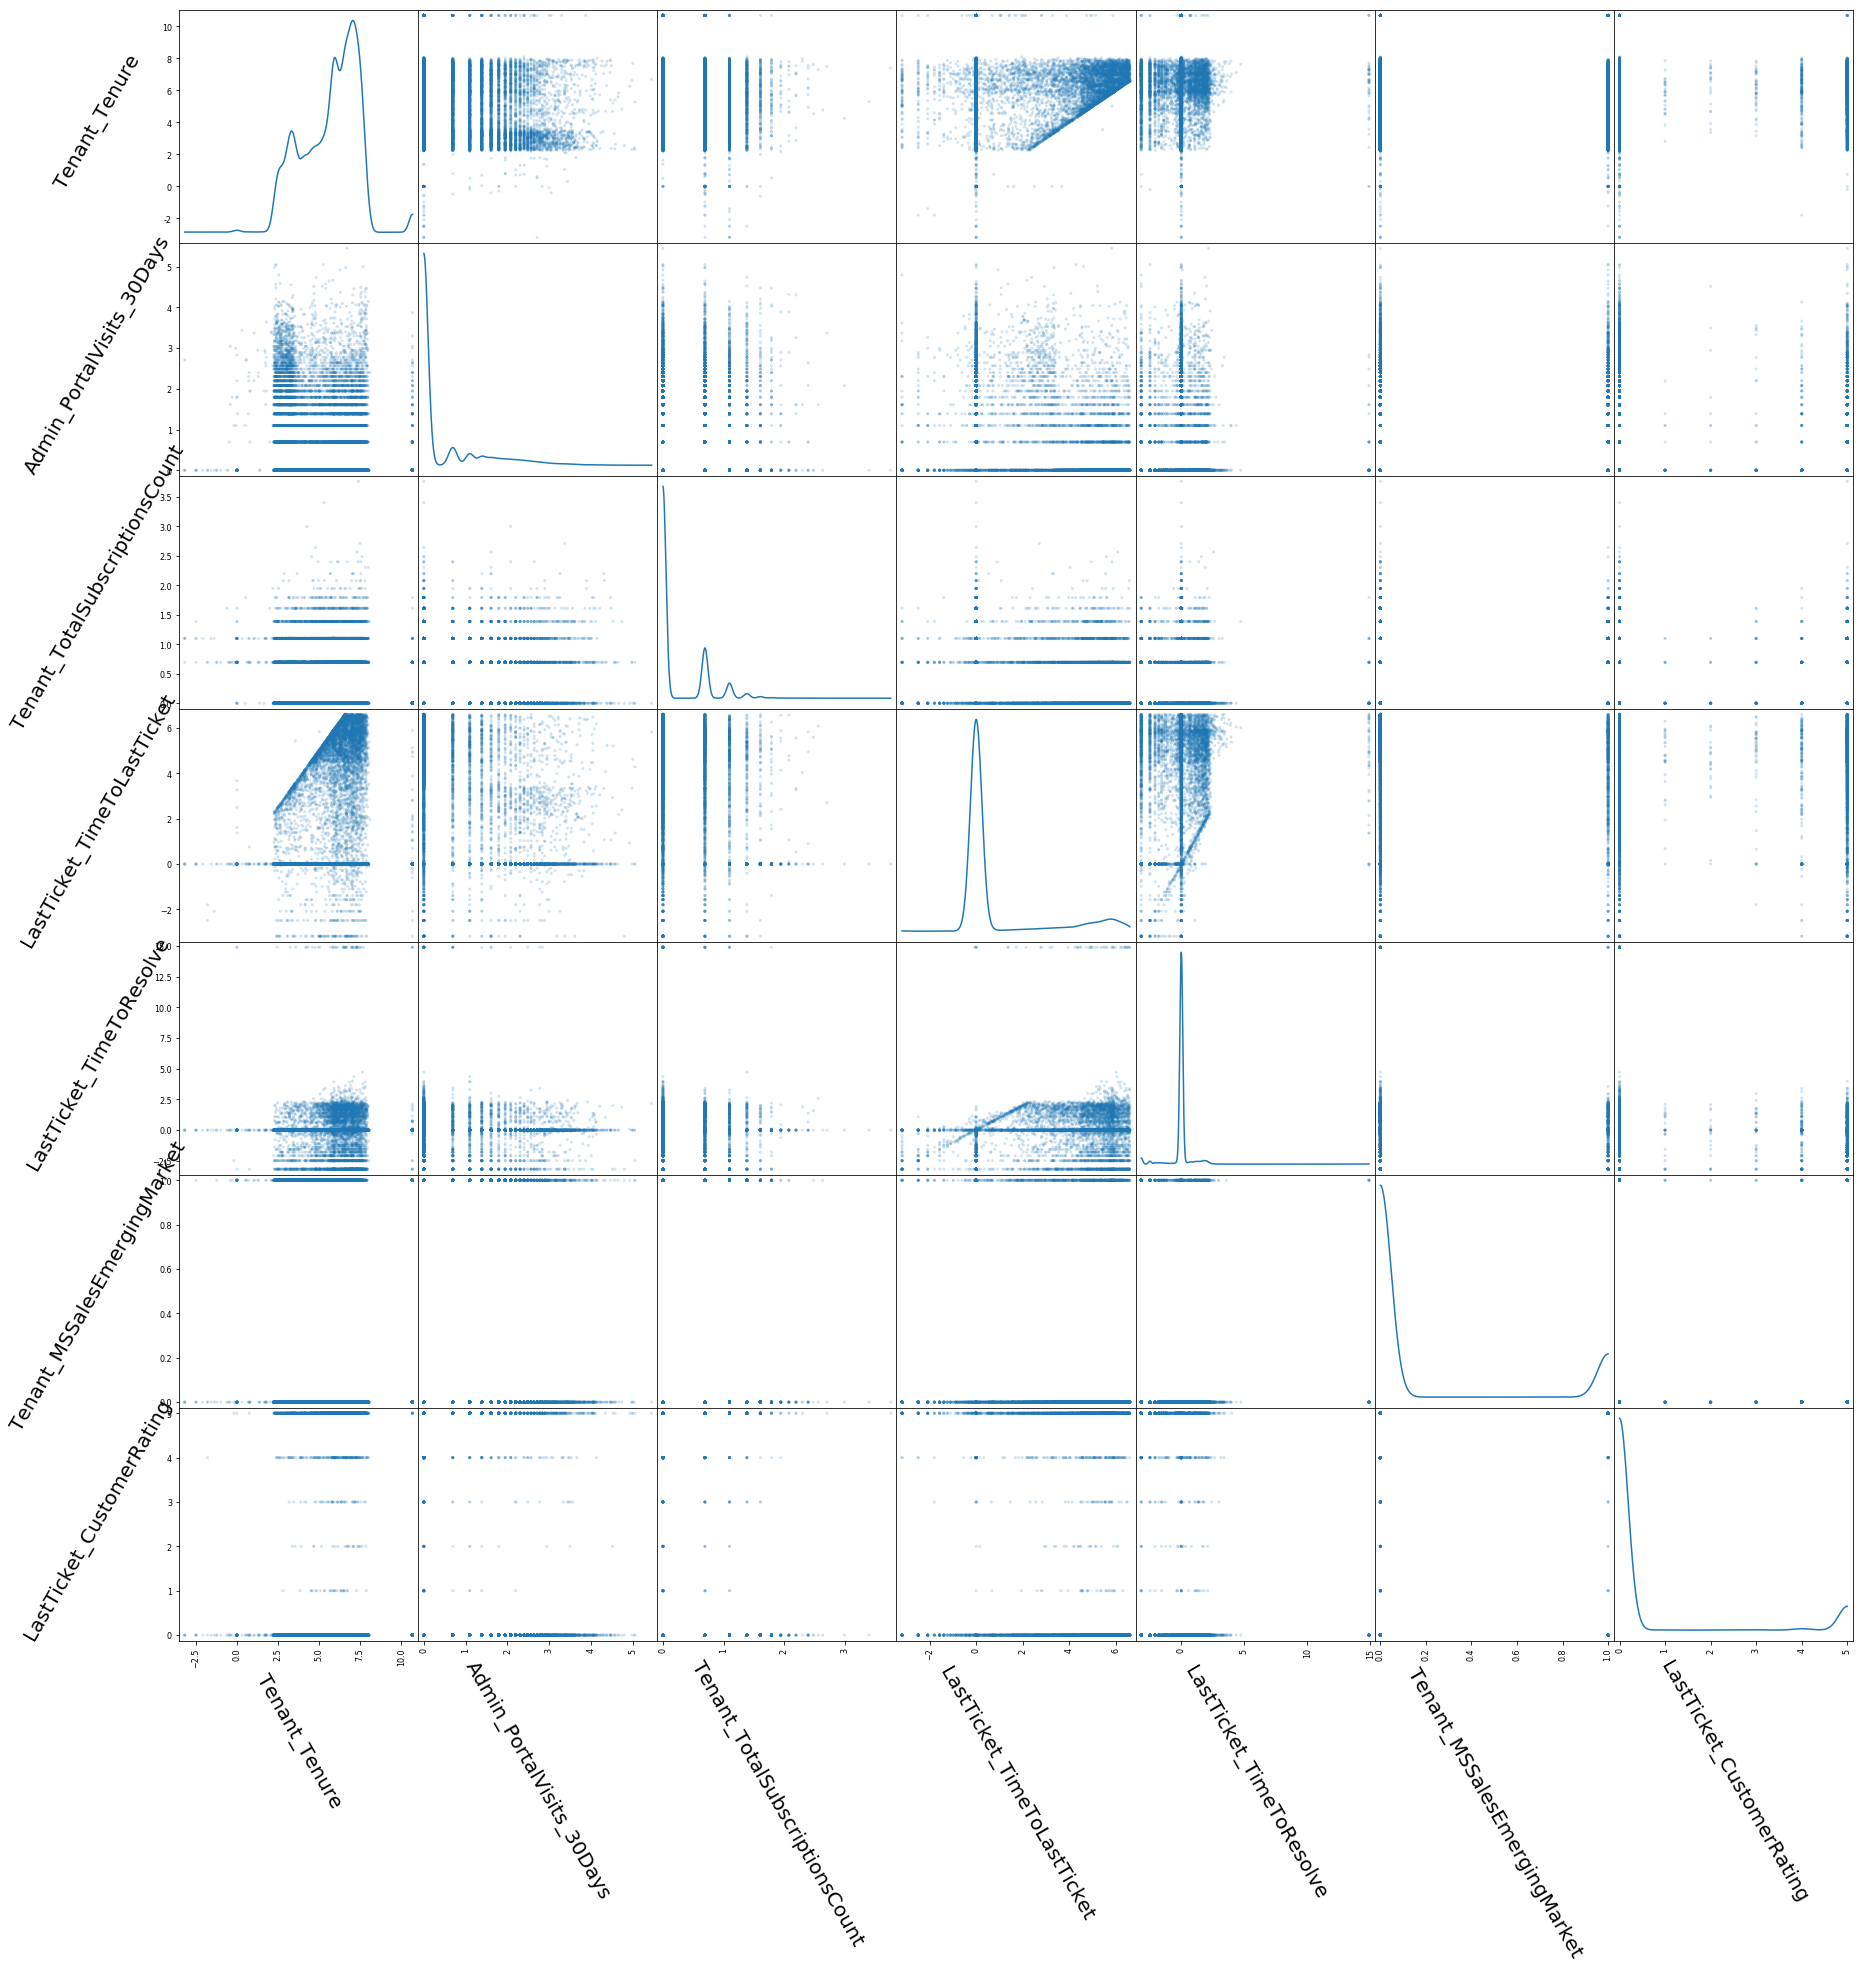

In [205]:
make_scatter_matrix(df_log[df_log.columns[df_log.dtypes=='float64']])

In [163]:
if 'Admin_PortalVisits_15Days' in df_log.columns:
    df_log.drop(columns='Admin_PortalVisits_15Days',inplace=True)

In [206]:
mlogit = sm.MNLogit(y, df_log.fillna(0))
fmlogit = mlogit.fit()

print(fmlogit.summary())

Optimization terminated successfully.
         Current function value: 0.936314
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    NPS   No. Observations:                33625
Model:                        MNLogit   Df Residuals:                    33581
Method:                           MLE   Df Model:                           42
Date:                Thu, 31 Oct 2019   Pseudo R-squ.:                 0.03608
Time:                        17:02:30   Log-Likelihood:                -31484.
converged:                       True   LL-Null:                       -32662.
                                        LLR p-value:                     0.000
                                                   NPS=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Tenant_Tenure   

## Binary Models:

In [207]:
mlogit = sm.Logit(y2, X_subset)
fmlogit = mlogit.fit()

print(fmlogit.summary())

Optimization terminated successfully.
         Current function value: 0.495259
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    NPS   No. Observations:                33625
Model:                          Logit   Df Residuals:                    33603
Method:                           MLE   Df Model:                           21
Date:                Thu, 31 Oct 2019   Pseudo R-squ.:                 0.04321
Time:                        17:02:30   Log-Likelihood:                -16653.
converged:                       True   LL-Null:                       -17405.
                                        LLR p-value:                4.312e-306
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Tenant_Tenure   

In [208]:
mlogit = sm.Logit(y2, df_log.fillna(0))
fmlogit = mlogit.fit()

print(fmlogit.summary())

Optimization terminated successfully.
         Current function value: 0.494975
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    NPS   No. Observations:                33625
Model:                          Logit   Df Residuals:                    33603
Method:                           MLE   Df Model:                           21
Date:                Thu, 31 Oct 2019   Pseudo R-squ.:                 0.04376
Time:                        17:02:30   Log-Likelihood:                -16644.
converged:                       True   LL-Null:                       -17405.
                                        LLR p-value:                3.422e-310
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Tenant_Tenure   

In [209]:
output = fmlogit.summary2().tables[1]

In [210]:
output['OddsRatio'] = np.exp(output['Coef.'])
output['OddsRatioLB'] = np.exp(output['[0.025'])
output['OddsRatioUB'] = np.exp(output['0.975]'])

In [211]:
DetractorDrivers = output[output['P>|z|']<0.1][output['Coef.']>0].round(2)

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [212]:
DetractorDrivers['Increase in Detractor Odds (As Percent)'] = DetractorDrivers['OddsRatio']*100 - 100

In [213]:
DetractorDrivers

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],OddsRatio,OddsRatioLB,OddsRatioUB,Increase in Detractor Odds (As Percent)
Admin_CanContact,0.28,0.03,8.95,0.00,0.22,0.34,1.32,1.24,1.41,32.0
Device_Browser_Firefox,0.14,0.04,3.40,0.00,0.06,0.22,1.15,1.06,1.25,15.0
Feedback_SystemLocale_en-US,0.07,0.03,2.08,0.04,0.00,0.13,1.07,1.00,1.14,7.0
Device_Browser_Safari,0.27,0.05,5.55,0.00,0.17,0.36,1.30,1.19,1.43,30.0
Admin_UsageSegment_Dormant,0.25,0.04,6.08,0.00,0.17,0.33,1.29,1.19,1.40,29.0
Tenant_CommunicationLanguage_nl,0.16,0.08,2.05,0.04,0.01,0.32,1.18,1.01,1.38,18.0
Feedback_SystemLocale_ja-JP,0.90,0.05,18.47,0.00,0.81,1.00,2.47,2.24,2.72,147.0


In [214]:
PromotorDrivers = output[output['P>|z|']<0.1][output['Coef.']<0].round(2)

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [215]:
PromotorDrivers

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],OddsRatio,OddsRatioLB,OddsRatioUB
Tenant_Tenure,-0.08,0.01,-13.01,0.00,-0.09,-0.07,0.92,0.91,0.93
Admin_PortalVisits_30Days,-0.05,0.02,-2.58,0.01,-0.08,-0.01,0.96,0.92,0.99
Tenant_TotalSubscriptionsCount,-0.19,0.04,-5.14,0.00,-0.26,-0.12,0.83,0.77,0.89
Admin_UsageSegment_Optimized,-0.36,0.04,-10.06,0.00,-0.43,-0.29,0.70,0.65,0.75
Admin_GeoName_eus,-0.18,0.04,-4.27,0.00,-0.26,-0.10,0.84,0.77,0.91
Tenant_MSSalesEmergingMarket,-0.70,0.05,-15.03,0.00,-0.79,-0.61,0.50,0.45,0.54
Tenant_MSSalesSubsidiaryPeerGroupingName_Developed Large,-0.10,0.05,-2.14,0.03,-0.19,-0.01,0.90,0.82,0.99
Admin_UsageSegment_Unknown,-0.46,0.04,-11.04,0.00,-0.54,-0.38,0.63,0.58,0.69
LastTicket_CustomerRating,-0.09,0.01,-8.38,0.00,-0.11,-0.07,0.91,0.89,0.93
Tenant_CommunicationLanguage_fr,-0.22,0.07,-3.09,0.00,-0.35,-0.08,0.81,0.70,0.92


In [216]:
PromotorDrivers['Decrease in Detractor Odds (As Percent)'] = PromotorDrivers['OddsRatio']*100 - 100
PromotorDrivers

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],OddsRatio,OddsRatioLB,OddsRatioUB,Decrease in Detractor Odds (As Percent)
Tenant_Tenure,-0.08,0.01,-13.01,0.00,-0.09,-0.07,0.92,0.91,0.93,-8.0
Admin_PortalVisits_30Days,-0.05,0.02,-2.58,0.01,-0.08,-0.01,0.96,0.92,0.99,-4.0
Tenant_TotalSubscriptionsCount,-0.19,0.04,-5.14,0.00,-0.26,-0.12,0.83,0.77,0.89,-17.0
Admin_UsageSegment_Optimized,-0.36,0.04,-10.06,0.00,-0.43,-0.29,0.70,0.65,0.75,-30.0
Admin_GeoName_eus,-0.18,0.04,-4.27,0.00,-0.26,-0.10,0.84,0.77,0.91,-16.0
Tenant_MSSalesEmergingMarket,-0.70,0.05,-15.03,0.00,-0.79,-0.61,0.50,0.45,0.54,-50.0
Tenant_MSSalesSubsidiaryPeerGroupingName_Developed Large,-0.10,0.05,-2.14,0.03,-0.19,-0.01,0.90,0.82,0.99,-10.0
Admin_UsageSegment_Unknown,-0.46,0.04,-11.04,0.00,-0.54,-0.38,0.63,0.58,0.69,-37.0
LastTicket_CustomerRating,-0.09,0.01,-8.38,0.00,-0.11,-0.07,0.91,0.89,0.93,-9.0
Tenant_CommunicationLanguage_fr,-0.22,0.07,-3.09,0.00,-0.35,-0.08,0.81,0.70,0.92,-19.0


Continuous variable interprataion:

* Tenant Tenure

* Admin Portal Visits in Last 30 Days

* Tenant Total Subscriptions Count


you can interpret the coefficient has having an effect on each multiple of the IV, rather than each addition of the IV.

One IV that often should be transformed is income. If you included it untransformed, then each (say) $1,000 increase in income would have an effect on the odds ratio as specified by the odds ratio. On the other hand, if you took log(10) of income, then each 10 fold increase in income would have the effect on the odds ratio specified in the odds ratio.

It makes sense to do this for income because, in many ways, an increase of 1,000 in income is much bigger for someone who makes 10,000 per year than someone who makes 100,000.

One final note - although logistic regression makes no normality assumptions, even OLS regression doesn't make assumptions about the variables, it makes assumptions about the error, as estimated by the residuals.

In [217]:
back_transform = PromotorDrivers.loc[['Tenant_Tenure','Tenant_TotalSubscriptionsCount'],:]

In [218]:
np.exp(1)**-0.07

0.9323938199059483

## Additional Analysis

In [ ]:
#sku type
#by promotor, passive, detractor

In [5]:
df = pd.read_csv('SingleSeatAdminOneYearTest.csv')
df.shape

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (22,84,211,214,291) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(14705, 312)

In [6]:
df.drop_duplicates(subset=['Feedback_TenantId'],inplace=True)
df.shape

(14597, 312)

In [7]:
df['Subscription_Sum_O365Business'] = (df['Subscription_Sum_O365Business'].fillna(0)!=0)*1 
df['Subscription_Sum_O365BusinessPremium'] =(df['Subscription_Sum_O365BusinessPremium'].fillna(0)!=0)*1

In [8]:
df['Subscription_Sum_O365BusinessPremium'].value_counts(dropna=False)

0    10256
1     4341
Name: Subscription_Sum_O365BusinessPremium, dtype: int64

In [9]:
skus = list(set(list(df.columns[df.columns.str.contains('SKU')])+list(df.columns[df.columns.str.contains('Business')])))

In [10]:

skus

['Tenant_HasOfficeSKUE1',
 'Tenant_HasM365SKUBusiness',
 'Tenant_HasOfficeSKUE3',
 'Tenant_HasM365SKUE5',
 'Tenant_HasM365SKUEdu',
 'Subscription_Sum_O365BusinessPremium',
 'Subscription_Sum_O365BusinessEssential',
 'Tenant_HasM365SKUE3',
 'Subscription_Sum_O365Business',
 'Tenant_HasOfficeSKUE5',
 'Tenant_HasOfficeSKUE4',
 'Tenant_HasM365SKUF1']

In [11]:
from statsmodels.graphics.mosaicplot import mosaic

In [12]:
df['NPS'].replace(-100,'Detractor',inplace=True)
df['NPS'].replace(0,'Passive',inplace=True)
df['NPS'].replace(100,'Promotor',inplace=True)

In [13]:
pd.DataFrame(data=['']).to_csv('SKUbyNPS.csv',index=False,header=None)
for sku in skus:
    counts = pd.crosstab(df['NPS'],df[sku].fillna(0),margins=True)
    print(counts)
    pd.DataFrame(data=[sku]).to_csv('SKUbyNPS.csv',mode='a',index=False,header=None)

    counts.to_csv('SKUbyNPS.csv',mode='a')
    pd.DataFrame(data=[' ']).to_csv('SKUbyNPS.csv',index=False,header=None,mode='a')
    #mosaic(df,['NPS',sku],title=sku+', 2X3 Distribution Plot')
    plt.show()

Tenant_HasOfficeSKUE1      0   1    All
NPS                                    
Detractor               3393  11   3404
Passive                 2976   9   2985
Promotor                8156  52   8208
All                    14525  72  14597
Tenant_HasM365SKUBusiness      0   1    All
NPS                                        
Detractor                   3392  12   3404
Passive                     2962  23   2985
Promotor                    8156  52   8208
All                        14510  87  14597
Tenant_HasOfficeSKUE3      0    1    All
NPS                                     
Detractor               3323   81   3404
Passive                 2884  101   2985
Promotor                7708  500   8208
All                    13915  682  14597
Tenant_HasM365SKUE5      0   1    All
NPS                                  
Detractor             3402   2   3404
Passive               2982   3   2985
Promotor              8173  35   8208
All                  14557  40  14597
Tenant_HasM365SKUEdu  

In [14]:
{x:1 for x in skus}

{'Tenant_HasOfficeSKUE1': 1,
 'Tenant_HasM365SKUBusiness': 1,
 'Tenant_HasOfficeSKUE3': 1,
 'Tenant_HasM365SKUE5': 1,
 'Tenant_HasM365SKUEdu': 1,
 'Subscription_Sum_O365BusinessPremium': 1,
 'Subscription_Sum_O365BusinessEssential': 1,
 'Tenant_HasM365SKUE3': 1,
 'Subscription_Sum_O365Business': 1,
 'Tenant_HasOfficeSKUE5': 1,
 'Tenant_HasOfficeSKUE4': 1,
 'Tenant_HasM365SKUF1': 1}

In [16]:
df.groupby('Feedback_Month').agg({x:sum for x in sorted(skus)}).to_csv('SenseiMatchingSKUs.csv')

### Distribution of Tenure

In [130]:
#Bucketized Tenure CDF plots
#by promotor, passive, detractor
import seaborn as sns
plt.style.use('seaborn')

In [39]:
TenureMonths = df.loc[:,["NPS","Tenant_Tenure"]]
TenureMonths['Tenant_Tenure'] = df['Tenant_Tenure']/30
TenureMonths = TenureMonths[TenureMonths['Tenant_Tenure']<500]

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Tenure Cumulative Distribution by NPS Class:')

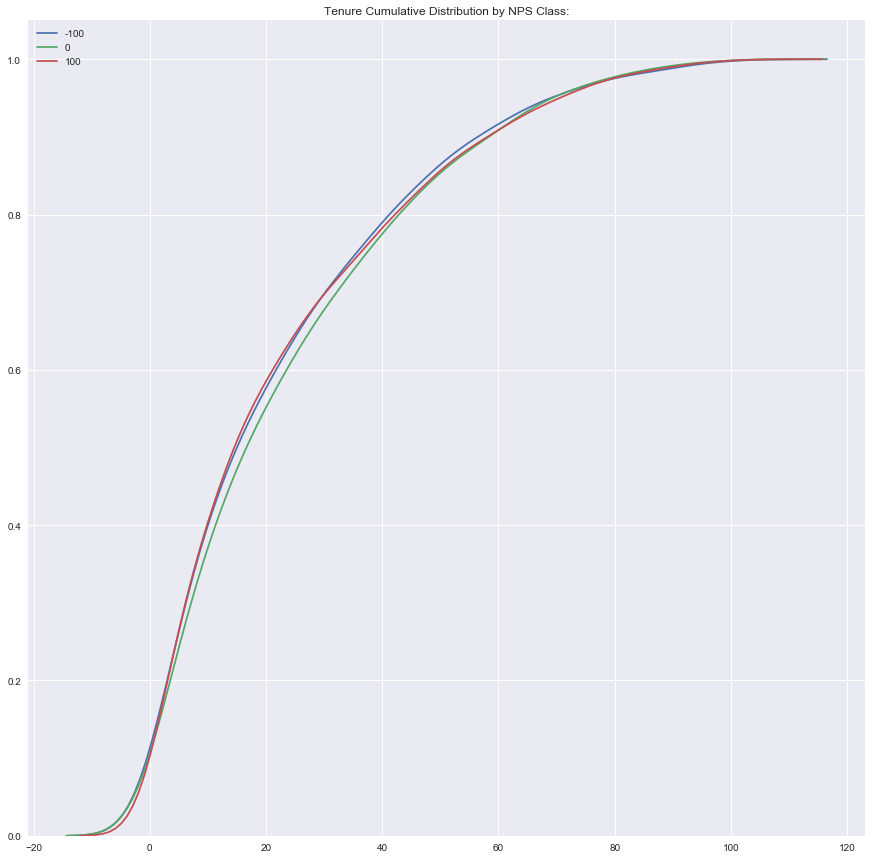

In [40]:
plt.figure(figsize=(15,15))
for n in sorted(TenureMonths.NPS.unique()):
    nps_df = TenureMonths[TenureMonths['NPS']==n]
    nps_df.rename(index=str,columns={'Tenant_Tenure':n},inplace=True)
    sns.kdeplot(nps_df[n],cumulative=True)
    
plt.title('Tenure Cumulative Distribution by NPS Class:')


In [120]:
df.Feedback_DateTime = pd.to_datetime(df.Feedback_DateTime)
df['month_year'] = df.Feedba

0        2019-06-01 07:50:28.0000000
1        2019-06-01 08:27:33.0000000
2        2019-06-01 08:37:29.0000000
3        2019-06-01 08:39:17.0000000
4        2019-06-01 09:25:42.0000000
5        2019-06-01 09:40:36.0000000
6        2019-06-01 10:23:22.0000000
7        2019-06-01 10:44:38.0000000
8        2019-06-01 11:57:39.0000000
9        2019-06-01 12:50:46.0000000
10       2019-06-01 13:54:40.0000000
11       2019-06-01 14:23:48.0000000
12       2019-06-01 15:07:10.0000000
13       2019-06-01 15:33:43.0000000
14       2019-06-01 15:49:00.0000000
15       2019-06-01 16:36:02.0000000
16       2019-06-01 16:45:02.0000000
17       2019-06-01 17:10:07.0000000
18       2019-06-01 17:29:17.0000000
19       2019-06-01 18:06:39.0000000
20       2019-06-01 18:07:29.0000000
21       2019-06-01 18:12:58.0000000
22       2019-06-01 18:17:14.0000000
23       2019-06-01 18:57:13.0000000
24       2019-06-01 20:53:57.0000000
25       2019-06-01 22:44:55.0000000
26       2019-06-01 23:24:34.0000000
2